In [1]:
# lineFit.py
# Simple python program to illustrate fitting with curve_fit
# G. Cowan / RHUL Physics / July 2025

import numpy as np
from scipy.optimize import curve_fit, least_squares
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':14})     # set all font sizes

In [2]:
# define fit function
def func(x, *theta):
    theta0, theta1 = theta
    return theta0 + theta1*x

# set data values
x   = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
y   = np.array([2.7, 3.9, 5.5, 5.8, 6.5, 6.3, 7.7, 8.5, 8.7])
sig = np.array([0.3, 0.5, 0.7, 0.6, 0.4, 0.3, 0.7, 0.8, 0.5])

# set default parameter values and do the fit
p0 = np.array([1.0, 1.0])
thetaHat, cov = curve_fit(func, x, y, p0, sig, absolute_sigma=True)

In [3]:
# Retrieve minimized chi-squared, etc.
numPoints = len(x)
numPar = len(p0)
ndof = numPoints - numPar
chi2_min = sum(((y - func(x, *thetaHat))/sig)**2)
print ("chi2_min = {chi2_min:.2f}", "    ndof = ", ndof)

# Print fit parameters and covariance matrix
print ("\n", "Fitted parameters and standard deviations:")
sigThetaHat = np.sqrt(np.diag(cov))
for i in range(len(thetaHat)):
    print ("thetaHat[", i, "] = ", thetaHat[i], "  +-  ", sigThetaHat[i])

print ("\n", "i, j, cov[i,j], rho[i,j]:")
for i in range(len(thetaHat)):
    for j in range(len(thetaHat)):
        rho = cov[i][j] / (sigThetaHat[i]*sigThetaHat[j])
        print (i, "  ", j, "  ", cov[i][j], "  ", rho)

chi2_min = {chi2_min:.2f}     ndof =  7

 Fitted parameters and standard deviations:
thetaHat[ 0 ] =  2.2576982022864116   +-   0.2921890938379292
thetaHat[ 1 ] =  0.7409333583240281   +-   0.05723132237774752

 i, j, cov[i,j], rho[i,j]:
0    0    0.08537446655783018    1.0
0    1    -0.01437632606434928    -0.8597063448892454
1    0    -0.01437632606434928    -0.8597063448892454
1    1    0.003275424261105664    0.9999999999999999


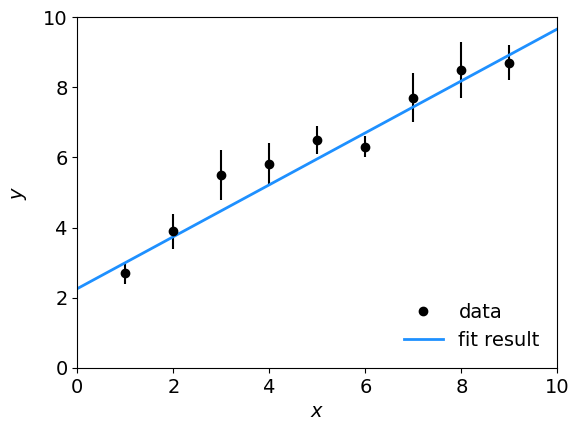

<Figure size 640x480 with 0 Axes>

In [4]:
# Set up plot
fig, ax = plt.subplots(1,1)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.errorbar(x, y, yerr=sig, xerr=0, color='black', fmt='o', label='data')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$', labelpad=10)
xMin = 0
xMax = 10
yMin = 0
yMax = 10
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
xPlot = np.linspace(xMin, xMax, 100)        # enough points for a smooth curve
fit = func(xPlot, *thetaHat)
plt.plot(xPlot, fit, 'dodgerblue', linewidth=2, label='fit result')

# Tweak legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
handles = [handles[0][0], handles[1]]      # turn off error bar in legend
plt.legend(handles, labels, loc='lower right', fontsize=14, frameon=False)

# Make and store plot
plt.show()
plt.savefig("simpleFit.pdf", format='pdf')

In [5]:
# ---------- helper with the safety guard ----------
def profile_chi2(grid_theta1, grid_theta2,
                 model, fixed_indices,
                 x, y, s, start):

    chi2 = np.empty_like(grid_theta1)
    fi, fj = fixed_indices
    all_idx  = range(len(start))
    free_idx = [k for k in all_idx if k not in fixed_indices]

    for i in range(grid_theta1.shape[0]):
        for j in range(grid_theta1.shape[1]):
            theta = start.copy()
            theta[fi], theta[fj] = grid_theta1[i, j], grid_theta2[i, j]

            if free_idx:                       # profile remaining params
                def resid(free_vals):
                    theta_tmp = theta.copy()
                    theta_tmp[free_idx] = free_vals
                    return (y - model(x, *theta_tmp)) / s

                res = least_squares(resid, theta[free_idx], method="trf")
                chi2[i, j] = 2.0 * res.cost    # res.cost = ½ Σ r_i²
            else:                              # nothing to optimise
                chi2[i, j] = np.sum(
                    ((y - model(x, *theta)) / s) ** 2
                )

    return chi2

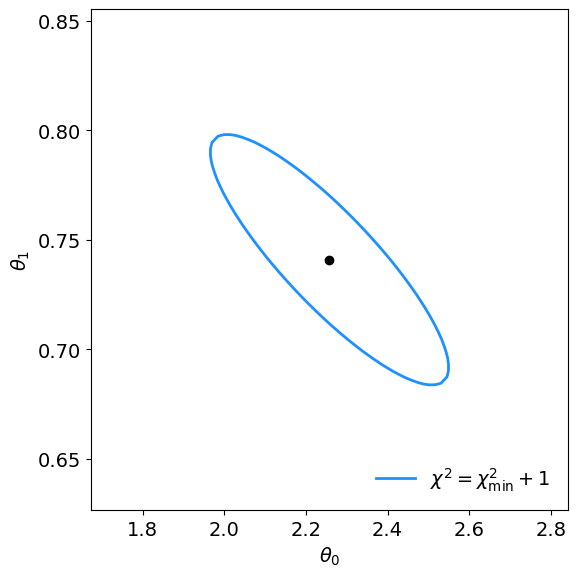

In [6]:
# ---------- build grid & plot Δχ² = 1 contour ----------
sig_0, sig_1 = np.sqrt(np.diag(cov))
grid_0 = np.linspace(thetaHat[0] - 2*sig_0, thetaHat[0] + 2*sig_0, 80)
grid_1 = np.linspace(thetaHat[1] - 2*sig_1, thetaHat[1] + 2*sig_1, 80)
theta_0, theta_1   = np.meshgrid(grid_0, grid_1)

chi2_prof = profile_chi2(theta_0, theta_1, func, (0, 1),
                         x, y, sig, thetaHat)

# --- after you have M, C and chi2_prof ---
fig, ax = plt.subplots(figsize=(6, 6))      # square figure
CS = ax.contour(theta_0, theta_1, chi2_prof,
                levels=[chi2_min + 1.0],
                colors='dodgerblue',
                linewidths=2)

# --- build a 1-D line object that looks like the contour ---------------
from matplotlib.lines import Line2D
proxy = Line2D([], [], color='dodgerblue', linewidth=2,
               label=r'$\chi^2 = \chi^2_{\rm min} + 1$')

ax.legend(handles=[proxy],             # any other handles can go here too
          loc='lower right',
          frameon=False)

ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel(r"$\theta_1$")

# ---- make the numeric spans equal -----------------------------------
x_mid = (theta_0.min() + theta_0.max()) / 2
y_mid = (theta_1.min() + theta_1.max()) / 2
half_span_x = theta_0.ptp() / 2    # ptp = max-min
half_span_y = theta_1.ptp() / 2
ax.set_xlim(x_mid - half_span_x, x_mid + half_span_x)
ax.set_ylim(y_mid - half_span_y, y_mid + half_span_y)
# ----------------------------------------------------------------------

plt.plot(thetaHat[0], thetaHat[1], 'o', color='black', label=r'LS estimates')
plt.tight_layout()
plt.show()